#### 1. Data collection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 3.0 MB/s 


In [4]:
import FinanceDataReader as fdr
import html5lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [5]:
import xgboost
import math
from sklearn.metrics import mean_squared_error

In [6]:
# KOSPI index, 2010 ~ Now
kospi = fdr.DataReader('KS11', '2009-01-01')

# Indexes, 2010 ~ Now
dji = fdr.DataReader('DJI', '2009-01-01') # Dow Jones Industrial(DJI)
sp500 = fdr.DataReader('US500', '2009-01-01') # S&P 500 지수 (NYSE)

# FX 환율, 2010 ~ 현재
usdkrw = fdr.DataReader('USD/KRW', '2009-01-01') # 달러 원화
usdeur = fdr.DataReader('USD/EUR', '2009-01-01') # 달러 유로화
usdcny = fdr.DataReader('USD/CNY', '2009-01-01') # 달러 위엔화

# 상품 선물 가격 데이터
gold = fdr.DataReader('ZG', '2009-01-01') # 금 선물 (ICE)

# 채권 수익률
kr1yt = fdr.DataReader('KR1YT=RR', '2009-01-01') # 1년만기 한국국채 수익률
kr10yt = fdr.DataReader('KR10YT=RR', '2009-01-01') # 10년만기 한국국채 수익률
us1yt = fdr.DataReader('US1MT=X', '2009-01-01') # 1개월 만기 미국국채 수익률
us10yt = fdr.DataReader('US10YT=X', '2009-01-01') # 10년 만기 미국국채 수익률

# FRED 데이터
nasdaq = fdr.DataReader('NASDAQCOM', '2009-01-01', data_source='fred') # NASDAQCOM 나스닥종합지수
# hou_nas = fdr.DataReader(['HSN1F', 'NASDAQCOM'], data_source='fred') # HSN1F 주택판매지수, NASDAQCOM 나스닥종합지수

sse = fdr.DataReader('005930', '2009-01-01')

#### 2. Preprocessing

In [ ]:
nasdaq.head()

,NASDAQCOM
DATE,
2009-01-02,1632.21
2009-01-05,1628.03
2009-01-06,1652.38
2009-01-07,1599.06
2009-01-08,1617.01


In [ ]:
kospi_m = pd.DataFrame(data=kospi.Close.values, columns=['kospi'], index=kospi.index)
dji_m = pd.DataFrame(data=dji.Close.values, columns=['dji'], index=dji.index)
sp500_m = pd.DataFrame(data=sp500.Close.values, columns=['sp500'], index=sp500.index)

usdkrw_m = pd.DataFrame(data=usdkrw.Close.values, columns=['usdkrw'], index=usdkrw.index)
usdeur_m = pd.DataFrame(data=usdeur.Close.values, columns=['usdeur'], index=usdeur.index)
usdcny_m = pd.DataFrame(data=usdcny.Close.values, columns=['usdcny'], index=usdcny.index)

gold_m = pd.DataFrame(data=gold.Close.values, columns=['gold'], index=gold.index)

kr1yt_m = pd.DataFrame(data=kr1yt.Close.values, columns=['kr1yt'], index=kr1yt.index)
kr10yt_m = pd.DataFrame(data=kr10yt.Close.values, columns=['kr10yt'], index=kr10yt.index)
us1yt_m = pd.DataFrame(data=us1yt.Close.values, columns=['us1yt'], index=us1yt.index)
us10yt_m = pd.DataFrame(data=us10yt.Close.values, columns=['us10yt'], index=us10yt.index)

nasdaq_m = pd.DataFrame(data=nasdaq.NASDAQCOM.values, columns=['nasdaq'], index=nasdaq.index)

sse_m = pd.DataFrame(data=sse.Close.values, columns=['sse'], index=sse.index)

In [ ]:
x_columns = [kospi_m, dji_m, sp500_m, usdkrw_m, usdeur_m, usdcny_m, gold_m, \
             kr1yt_m, kr10yt_m, us1yt_m, us10yt_m, nasdaq_m, sse_m]

In [ ]:
df = pd.concat(x_columns, axis=1)

In [ ]:
df.head()

,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse
2009-01-01,NaN,NaN,NaN,1263.0,0.7147,6.8230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-02,1157.40,9034.69,931.80,1321.0,0.7206,6.8230,878.8,3.17,4.23,0.020,2.361,1632.21,9400.0
2009-01-05,1173.57,8952.89,927.45,1315.0,0.7350,6.8305,857.2,2.93,4.22,0.046,2.485,1628.03,9520.0
2009-01-06,1194.28,9015.10,934.70,1312.0,0.7401,6.8365,865.4,2.88,4.26,0.041,2.450,1652.38,9960.0
2009-01-07,1228.17,8769.70,906.65,1292.7,0.7333,6.8335,841.1,2.95,4.31,0.051,2.498,1599.06,10480.0


In [ ]:
df.tail()

,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse
2022-06-13,2504.51,30518.06,3749.63,1291.68,0.9607,6.7530,1831.8,2.426,3.644,1.1060,3.362,10809.23,62100.0
2022-06-14,2492.97,30365.95,3735.48,1289.57,0.9598,6.7395,1813.5,2.445,3.697,1.1590,3.479,10828.35,61900.0
2022-06-15,2447.38,30668.27,3789.99,1277.90,0.9573,6.7128,1819.6,2.600,3.803,1.1720,3.292,11099.15,60700.0
2022-06-16,2451.41,29929.31,3666.77,1288.45,0.9481,6.7048,NaN,2.514,3.760,1.2434,3.195,NaN,60900.0
2022-06-17,2415.85,NaN,NaN,1290.02,0.9488,6.7036,NaN,NaN,3.764,NaN,3.265,NaN,59800.0


In [ ]:
# df_dropna = df.dropna(axis=0, how='any')
df_dropna = df.fillna(method='ffill')

In [ ]:
df_dropna.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4406 entries, 2009-01-01 to 2022-06-17
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kospi   4405 non-null   float64
 1   dji     4405 non-null   float64
 2   sp500   4405 non-null   float64
 3   usdkrw  4406 non-null   float64
 4   usdeur  4406 non-null   float64
 5   usdcny  4406 non-null   float64
 6   gold    4405 non-null   float64
 7   kr1yt   4405 non-null   float64
 8   kr10yt  4405 non-null   float64
 9   us1yt   4405 non-null   float64
 10  us10yt  4405 non-null   float64
 11  nasdaq  4405 non-null   float64
 12  sse     4405 non-null   float64
dtypes: float64(13)
memory usage: 481.9 KB


In [ ]:
df_dropna = df_dropna.drop(['2009-01-01'])

In [ ]:
df_dropna.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4405 entries, 2009-01-02 to 2022-06-17
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kospi   4405 non-null   float64
 1   dji     4405 non-null   float64
 2   sp500   4405 non-null   float64
 3   usdkrw  4405 non-null   float64
 4   usdeur  4405 non-null   float64
 5   usdcny  4405 non-null   float64
 6   gold    4405 non-null   float64
 7   kr1yt   4405 non-null   float64
 8   kr10yt  4405 non-null   float64
 9   us1yt   4405 non-null   float64
 10  us10yt  4405 non-null   float64
 11  nasdaq  4405 non-null   float64
 12  sse     4405 non-null   float64
dtypes: float64(13)
memory usage: 481.8 KB


In [ ]:
full_df = df_dropna.reset_index()

In [ ]:
full_df.head()

,index,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse
0,2009-01-02,1157.40,9034.69,931.80,1321.0,0.7206,6.8230,878.8,3.17,4.23,0.020,2.361,1632.21,9400.0
1,2009-01-05,1173.57,8952.89,927.45,1315.0,0.7350,6.8305,857.2,2.93,4.22,0.046,2.485,1628.03,9520.0
2,2009-01-06,1194.28,9015.10,934.70,1312.0,0.7401,6.8365,865.4,2.88,4.26,0.041,2.450,1652.38,9960.0
3,2009-01-07,1228.17,8769.70,906.65,1292.7,0.7333,6.8335,841.1,2.95,4.31,0.051,2.498,1599.06,10480.0
4,2009-01-08,1205.70,8742.46,909.73,1330.0,0.7286,6.8347,853.9,2.84,4.20,0.041,2.445,1617.01,10160.0


In [ ]:
# feature 추가할 것들 고려

# kospi 이동평균선 추가

full_df['kospi_sma5'] = full_df['kospi'].rolling(5).mean()
full_df['kospi_sma20'] = full_df['kospi'].rolling(20).mean()
full_df['kospi_sma100'] = full_df['kospi'].rolling(100).mean()
full_df['kospi_sma200'] = full_df['kospi'].rolling(200).mean()

# dji 이동평균선 추가

full_df['dji_sma5'] = full_df['dji'].rolling(5).mean()
full_df['dji_sma20'] = full_df['dji'].rolling(20).mean()
full_df['dji_sma100'] = full_df['dji'].rolling(100).mean()
full_df['dji_sma200'] = full_df['dji'].rolling(200).mean()


# sp500 이동평균선 추가

full_df['sp500_sma5'] = full_df['sp500'].rolling(5).mean()
full_df['sp500_sma20'] = full_df['sp500'].rolling(20).mean()
full_df['sp500_sma100'] = full_df['sp500'].rolling(100).mean()
full_df['sp500_sma200'] = full_df['sp500'].rolling(200).mean()

# usdkrw 이동평균선 추가

full_df['usdkrw_sma5'] = full_df['usdkrw'].rolling(5).mean()
full_df['usdkrw_sma20'] = full_df['usdkrw'].rolling(20).mean()
full_df['usdkrw_sma100'] = full_df['usdkrw'].rolling(100).mean()
full_df['usdkrw_sma200'] = full_df['usdkrw'].rolling(200).mean()

# gold 이동평균선 추가

full_df['gold_sma5'] = full_df['gold'].rolling(5).mean()
full_df['gold_sma20'] = full_df['gold'].rolling(20).mean()
full_df['gold_sma100'] = full_df['gold'].rolling(100).mean()
full_df['gold_sma200'] = full_df['gold'].rolling(200).mean()

# nasdaq 이동평균선 추가

full_df['nasdaq_sma5'] = full_df['nasdaq'].rolling(5).mean()
full_df['nasdaq_sma20'] = full_df['nasdaq'].rolling(20).mean()
full_df['nasdaq_sma100'] = full_df['nasdaq'].rolling(100).mean()
full_df['nasdaq_sma200'] = full_df['nasdaq'].rolling(200).mean()

In [ ]:
full_df.head()

,index,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,...,usdkrw_sma100,usdkrw_sma200,gold_sma5,gold_sma20,gold_sma100,gold_sma200,nasdaq_sma5,nasdaq_sma20,nasdaq_sma100,nasdaq_sma200
0,2009-01-02,1157.40,9034.69,931.80,1321.0,0.7206,6.8230,878.8,3.17,4.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-05,1173.57,8952.89,927.45,1315.0,0.7350,6.8305,857.2,2.93,4.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-06,1194.28,9015.10,934.70,1312.0,0.7401,6.8365,865.4,2.88,4.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-07,1228.17,8769.70,906.65,1292.7,0.7333,6.8335,841.1,2.95,4.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-08,1205.70,8742.46,909.73,1330.0,0.7286,6.8347,853.9,2.84,4.20,...,NaN,NaN,859.28,NaN,NaN,NaN,1625.738,NaN,NaN,NaN


In [ ]:
full_df[full_df['index'] == '2010-01-01']

,index,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,...,usdkrw_sma100,usdkrw_sma200,gold_sma5,gold_sma20,gold_sma100,gold_sma200,nasdaq_sma5,nasdaq_sma20,nasdaq_sma100,nasdaq_sma200
260,2010-01-01,1682.77,10428.05,1115.1,1166.08,0.6981,6.827,1095.2,3.38,5.4,...,1186.5438,1231.0234,1097.22,1111.975,1060.247,994.6525,2281.812,2233.9855,2129.5422,1957.3572


In [ ]:
first_df = full_df.iloc[260:]
first_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145 entries, 260 to 4404
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          4145 non-null   datetime64[ns]
 1   kospi          4145 non-null   float64       
 2   dji            4145 non-null   float64       
 3   sp500          4145 non-null   float64       
 4   usdkrw         4145 non-null   float64       
 5   usdeur         4145 non-null   float64       
 6   usdcny         4145 non-null   float64       
 7   gold           4145 non-null   float64       
 8   kr1yt          4145 non-null   float64       
 9   kr10yt         4145 non-null   float64       
 10  us1yt          4145 non-null   float64       
 11  us10yt         4145 non-null   float64       
 12  nasdaq         4145 non-null   float64       
 13  sse            4145 non-null   float64       
 14  kospi_sma5     4145 non-null   float64       
 15  kospi_sma20    4145

In [ ]:
first_df.reset_index(drop = True, inplace = True)
first_df

,index,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,...,usdkrw_sma100,usdkrw_sma200,gold_sma5,gold_sma20,gold_sma100,gold_sma200,nasdaq_sma5,nasdaq_sma20,nasdaq_sma100,nasdaq_sma200
0,2010-01-01,1682.77,10428.05,1115.10,1166.08,0.6981,6.8270,1095.2,3.380,5.400,...,1186.5438,1231.02340,1097.22,1111.975,1060.247,994.6525,2281.812,2233.9855,2129.5422,1957.35720
1,2010-01-04,1696.14,10583.96,1132.99,1150.00,0.6937,6.8285,1117.7,3.470,5.420,...,1185.4538,1229.78965,1099.32,1109.690,1062.081,995.6635,2285.280,2239.9260,2133.3180,1961.39030
2,2010-01-05,1690.62,10572.02,1136.52,1140.20,0.6960,6.8268,1118.1,3.470,5.360,...,1184.3758,1228.62040,1103.54,1108.455,1063.885,996.6410,2289.342,2246.7120,2136.8459,1965.29090
3,2010-01-06,1705.32,10573.68,1137.14,1129.20,0.6938,6.8278,1135.9,3.440,5.380,...,1183.1528,1227.39890,1112.42,1109.230,1065.811,997.6900,2291.304,2252.5800,2140.1644,1969.03835
4,2010-01-07,1683.45,10606.86,1141.69,1138.20,0.6985,6.8281,1133.1,3.430,5.300,...,1182.0798,1226.43740,1120.00,1109.600,1067.739,998.8185,2297.484,2258.0395,2143.2727,1972.52545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4140,2022-06-13,2504.51,30518.06,3749.63,1291.68,0.9607,6.7530,1831.8,2.426,3.644,...,1244.8115,1218.59290,1858.42,1855.700,1912.406,1869.9265,11465.954,11848.0835,12786.3112,13760.39745
4141,2022-06-14,2492.97,30365.95,3735.48,1289.57,0.9598,6.7395,1813.5,2.445,3.697,...,1245.5327,1219.09035,1849.82,1852.805,1910.805,1869.9220,11214.370,11826.2785,12761.4603,13735.26540
4142,2022-06-15,2447.38,30668.27,3789.99,1277.90,0.9573,6.7128,1819.6,2.600,3.803,...,1246.1372,1219.53445,1843.18,1851.160,1909.265,1870.0615,11083.354,11809.4990,12739.3174,13711.88545
4143,2022-06-16,2451.41,29929.31,3666.77,1288.23,0.9477,6.7030,1849.9,2.514,3.760,...,1246.8450,1220.03175,1838.06,1850.960,1908.028,1870.3495,11035.180,11777.4240,12717.1745,13688.15505


In [ ]:
to_scale_df = first_df.loc[: , 'kospi':]

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardization 평균 0 / 분산 1
scaler = StandardScaler()   

scaler_df = scaler.fit_transform(to_scale_df)

In [ ]:
scaler_df

array([[-1.35295261, -1.44377634, -1.36399215, ..., -1.1719749 ,
        -1.18421301, -1.216943  ],
       [-1.31671902, -1.4222289 , -1.34517424, ..., -1.17034745,
        -1.18316919, -1.21580543],
       [-1.33167858, -1.42387906, -1.34146115, ..., -1.16848837,
        -1.1821939 , -1.21470524],
       ...,
       [ 0.71919137,  1.35350942,  1.44963744, ...,  1.45131815,
         1.74886623,  2.09851151],
       [ 0.73011294,  1.25138196,  1.32002634, ...,  1.44253094,
         1.74274482,  2.09181817],
       [ 0.70171144,  1.25138196,  1.32002634, ...,  1.42839495,
         1.73795722,  2.08512483]])

In [ ]:
kospi_dji_compare = []
for i in scaler_df:
  kospi_dji_compare.append(i[0]-i[1])
len(kospi_dji_compare)

4145

In [ ]:
first_df.columns

Index(['index', 'kospi', 'dji', 'sp500', 'usdkrw', 'usdeur', 'usdcny', 'gold',
       'kr1yt', 'kr10yt', 'us1yt', 'us10yt', 'nasdaq', 'sse', 'kospi_sma5',
       'kospi_sma20', 'kospi_sma100', 'kospi_sma200', 'dji_sma5', 'dji_sma20',
       'dji_sma100', 'dji_sma200', 'sp500_sma5', 'sp500_sma20', 'sp500_sma100',
       'sp500_sma200', 'usdkrw_sma5', 'usdkrw_sma20', 'usdkrw_sma100',
       'usdkrw_sma200', 'gold_sma5', 'gold_sma20', 'gold_sma100',
       'gold_sma200', 'nasdaq_sma5', 'nasdaq_sma20', 'nasdaq_sma100',
       'nasdaq_sma200'],
      dtype='object')

In [ ]:
ko_oth_compare = pd.DataFrame(kospi_dji_compare)
ko_oth_compare.shape

(4145, 1)

In [ ]:
compare_name = ['0', 'dji', 'sp500', 'usdkrw', 'usdeur', 'usdcny', 'gold',
       'kr1yt', 'kr10yt', 'us1yt', 'us10yt', 'nasdaq', 'sse', 'kospi_sma5',
       'kospi_sma20', 'kospi_sma100', 'kospi_sma200', 'dji_sma5', 'dji_sma20',
       'dji_sma100', 'dji_sma200', 'sp500_sma5', 'sp500_sma20', 'sp500_sma100',
       'sp500_sma200', 'usdkrw_sma5', 'usdkrw_sma20', 'usdkrw_sma100',
       'usdkrw_sma200', 'gold_sma5', 'gold_sma20', 'gold_sma100',
       'gold_sma200', 'nasdaq_sma5', 'nasdaq_sma20', 'nasdaq_sma100',
       'nasdaq_sma200']
ko_oth_compare = pd.DataFrame()

for j in range(36):
  tmp = []
  for i in scaler_df:
    tmp.append(i[0]-i[j])
  tmp = pd.DataFrame(tmp) 
  ko_oth_compare = pd.concat([ko_oth_compare, tmp], axis=1)
ko_oth_compare.shape

(4145, 36)

In [ ]:
tmp_name = ""
tmp_columns = []
for i in range(36):
  tmp_name = ("kospi_{}_compare".format(compare_name[i]))
  tmp_columns.append(tmp_name)

tmp_columns

['kospi_0_compare',
 'kospi_dji_compare',
 'kospi_sp500_compare',
 'kospi_usdkrw_compare',
 'kospi_usdeur_compare',
 'kospi_usdcny_compare',
 'kospi_gold_compare',
 'kospi_kr1yt_compare',
 'kospi_kr10yt_compare',
 'kospi_us1yt_compare',
 'kospi_us10yt_compare',
 'kospi_nasdaq_compare',
 'kospi_sse_compare',
 'kospi_kospi_sma5_compare',
 'kospi_kospi_sma20_compare',
 'kospi_kospi_sma100_compare',
 'kospi_kospi_sma200_compare',
 'kospi_dji_sma5_compare',
 'kospi_dji_sma20_compare',
 'kospi_dji_sma100_compare',
 'kospi_dji_sma200_compare',
 'kospi_sp500_sma5_compare',
 'kospi_sp500_sma20_compare',
 'kospi_sp500_sma100_compare',
 'kospi_sp500_sma200_compare',
 'kospi_usdkrw_sma5_compare',
 'kospi_usdkrw_sma20_compare',
 'kospi_usdkrw_sma100_compare',
 'kospi_usdkrw_sma200_compare',
 'kospi_gold_sma5_compare',
 'kospi_gold_sma20_compare',
 'kospi_gold_sma100_compare',
 'kospi_gold_sma200_compare',
 'kospi_nasdaq_sma5_compare',
 'kospi_nasdaq_sma20_compare',
 'kospi_nasdaq_sma100_compare']

In [ ]:
len(tmp_columns)

36

In [ ]:
# columns rename
#ko_oth_compare.rename(columns = tmp_columns, inplace = True)
ko_oth_compare.columns = tmp_columns
ko_oth_compare

,kospi_0_compare,kospi_dji_compare,kospi_sp500_compare,kospi_usdkrw_compare,kospi_usdeur_compare,kospi_usdcny_compare,kospi_gold_compare,kospi_kr1yt_compare,kospi_kr10yt_compare,kospi_us1yt_compare,...,kospi_usdkrw_sma20_compare,kospi_usdkrw_sma100_compare,kospi_usdkrw_sma200_compare,kospi_gold_sma5_compare,kospi_gold_sma20_compare,kospi_gold_sma100_compare,kospi_gold_sma200_compare,kospi_nasdaq_sma5_compare,kospi_nasdaq_sma20_compare,kospi_nasdaq_sma100_compare
0,0.0,0.090824,0.011040,-1.993602,0.610243,-2.359365,0.058152,-3.121310,-4.209218,-0.730008,...,-2.064158,-2.562063,-3.739230,0.050484,-0.008618,0.202391,0.465381,-0.190739,-0.180978,-0.168740
1,0.0,0.105510,0.028455,-1.635423,0.709254,-2.328346,0.004281,-3.195147,-4.193787,-0.704449,...,-2.020213,-2.501189,-3.672897,0.078296,0.036816,0.231077,0.497364,-0.155455,-0.146372,-0.133550
2,0.0,0.092200,0.009783,-1.454173,0.661479,-2.337396,-0.012280,-3.210107,-4.146339,-0.706066,...,-2.018701,-2.491780,-3.659331,0.046415,0.026829,0.208695,0.478295,-0.171526,-0.163190,-0.149485
3,0.0,0.131809,0.048968,-1.194098,0.732706,-2.301034,-0.043724,-3.133578,-4.127304,-0.651551,...,-1.946680,-2.424295,-3.589693,0.050645,0.063546,0.240607,0.513723,-0.132225,-0.124960,-0.110564
4,0.0,0.067954,-0.015087,-1.433561,0.606379,-2.361346,-0.091780,-3.180617,-4.103363,-0.704149,...,-1.977879,-2.459308,-3.625505,-0.039020,0.002787,0.173405,0.449710,-0.193185,-0.185725,-0.170693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4140,0.0,-0.458732,-0.533167,-2.281327,-0.909472,0.124848,-0.664681,0.272412,-0.155790,0.071987,...,-1.657942,-1.652285,-1.208999,-0.774907,-0.776086,-1.077191,-0.987270,-0.477063,-0.587871,-0.887840
4141,0.0,-0.468984,-0.549557,-2.270356,-0.927906,0.140503,-0.622670,0.217901,-0.242191,-0.030002,...,-1.718561,-1.699862,-1.252409,-0.771696,-0.795704,-1.101878,-1.018525,-0.439490,-0.613172,-0.912244
4142,0.0,-0.634318,-0.730446,-2.160257,-1.015788,0.109767,-0.770650,-0.095218,-0.475996,-0.170899,...,-1.853927,-1.837080,-1.386795,-0.868622,-0.912633,-1.219093,-1.142664,-0.527189,-0.732127,-1.029675
4143,0.0,-0.521269,-0.589913,-2.356158,-0.867897,0.154756,-0.881069,0.020882,-0.420349,-0.255242,...,-1.872011,-1.842158,-1.388006,-0.837170,-0.900906,-1.203081,-1.132953,-0.503084,-0.712418,-1.012632


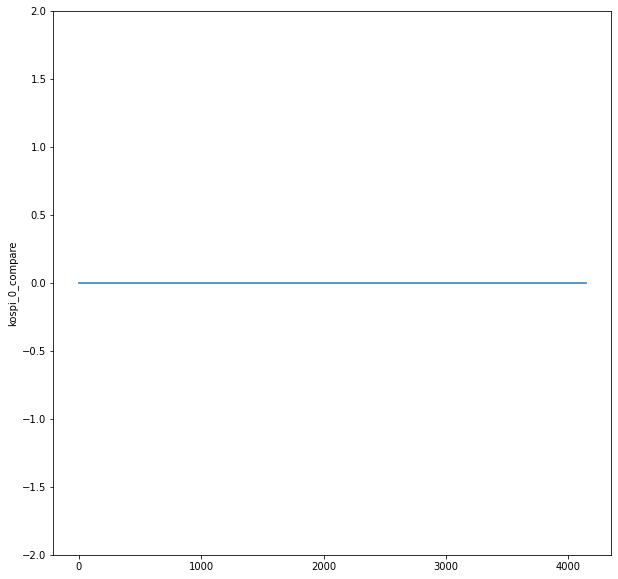

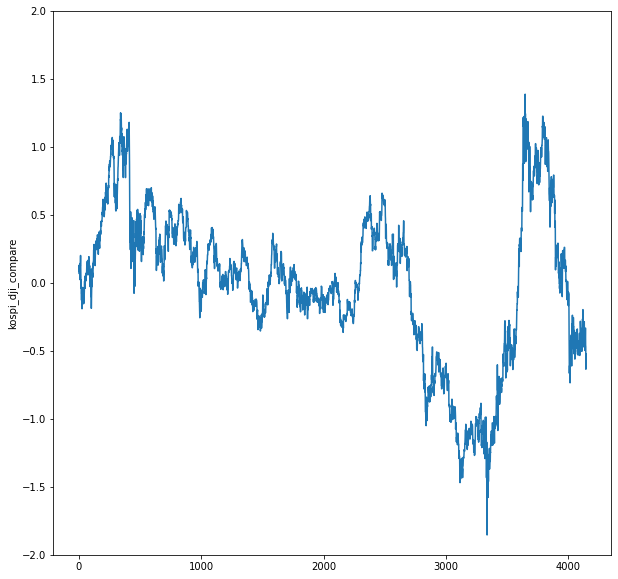

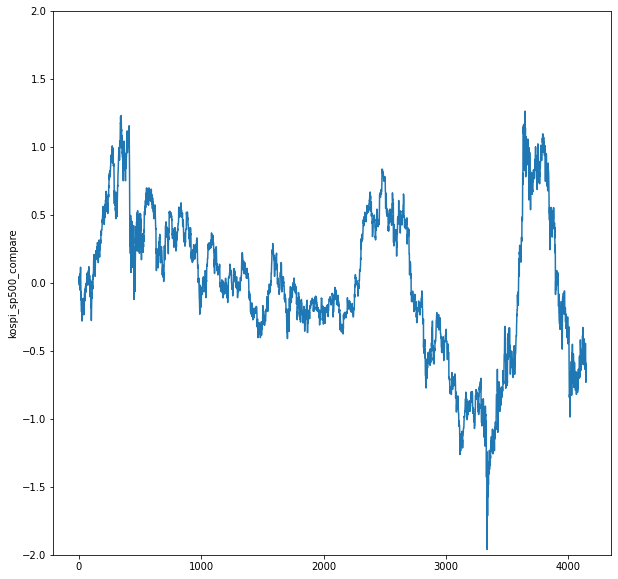

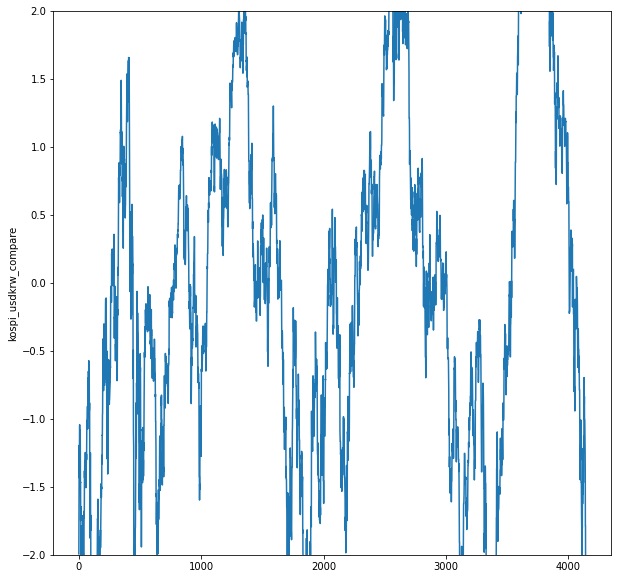

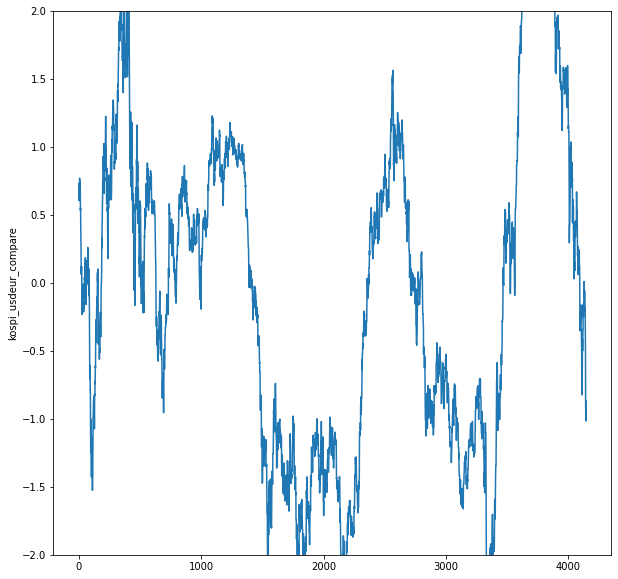

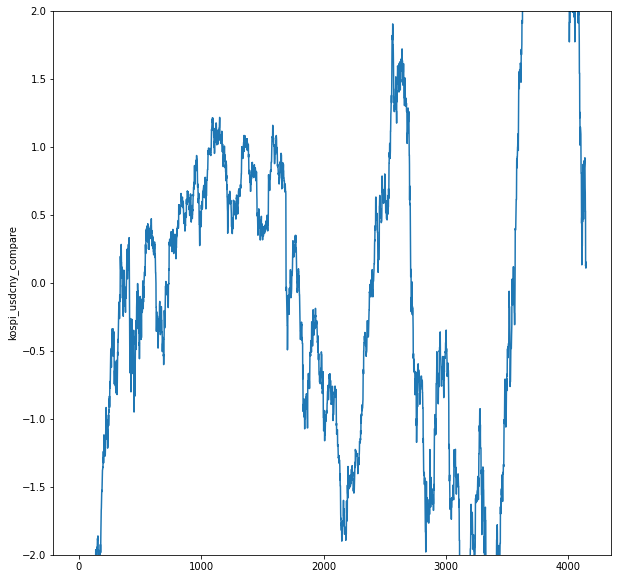

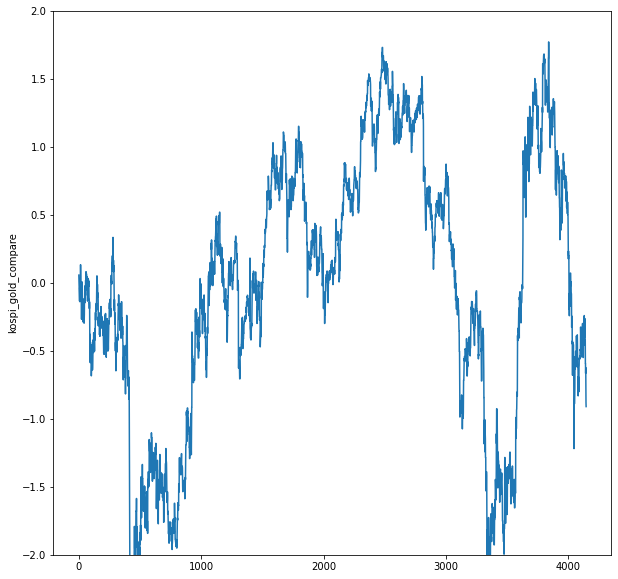

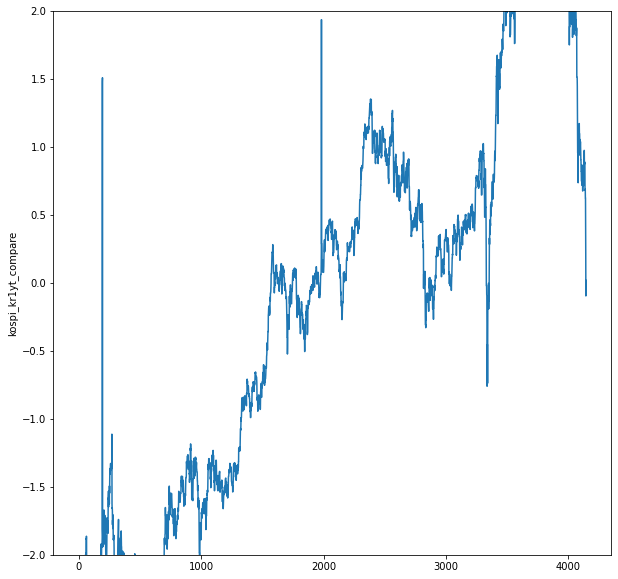

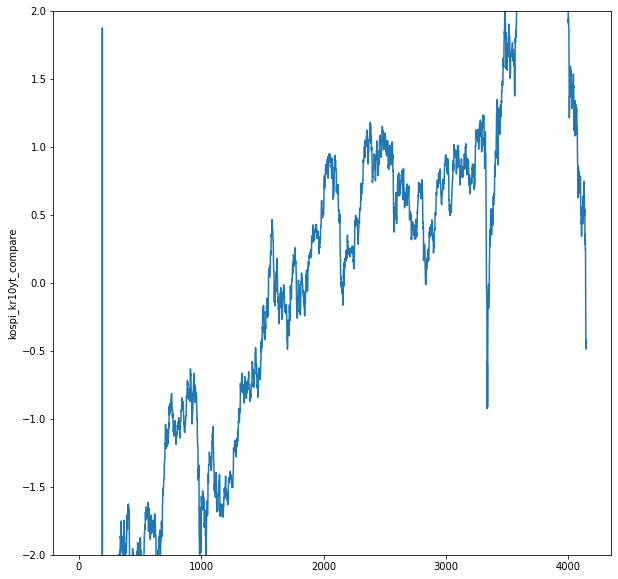

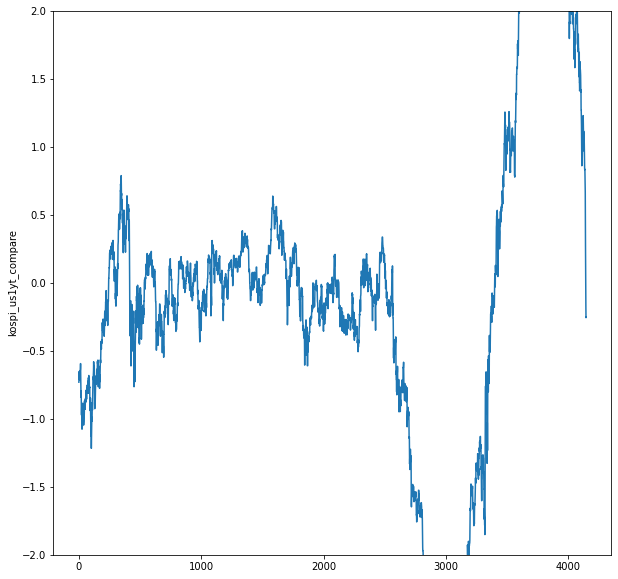

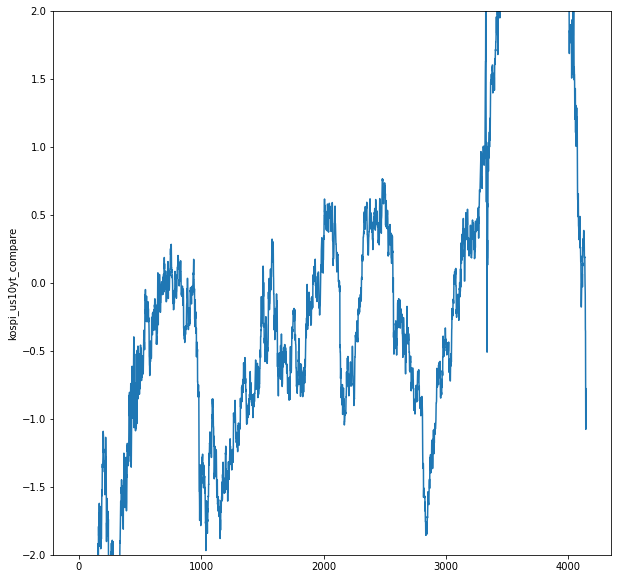

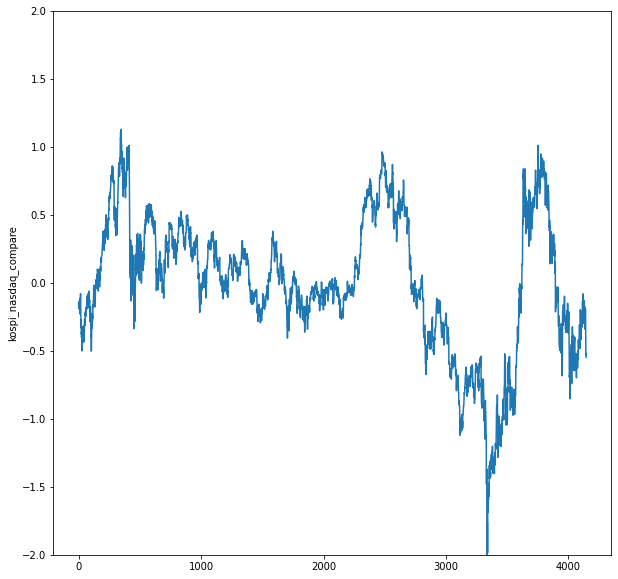

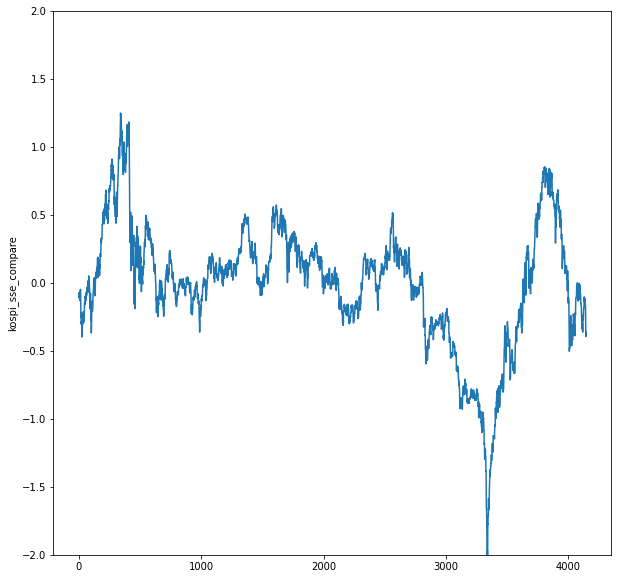

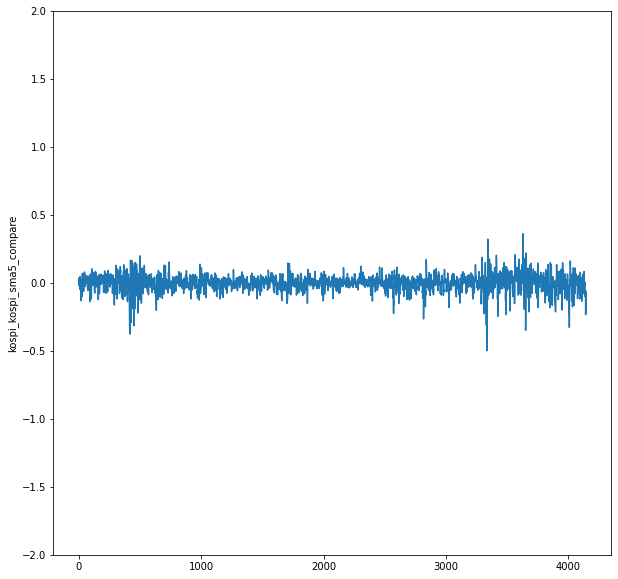

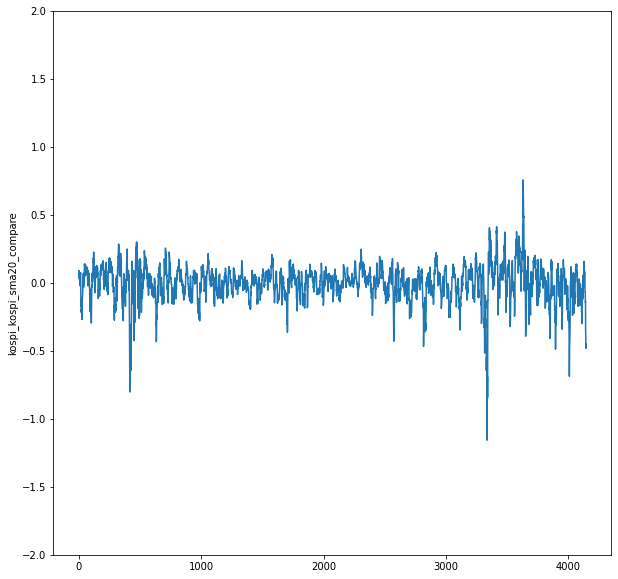

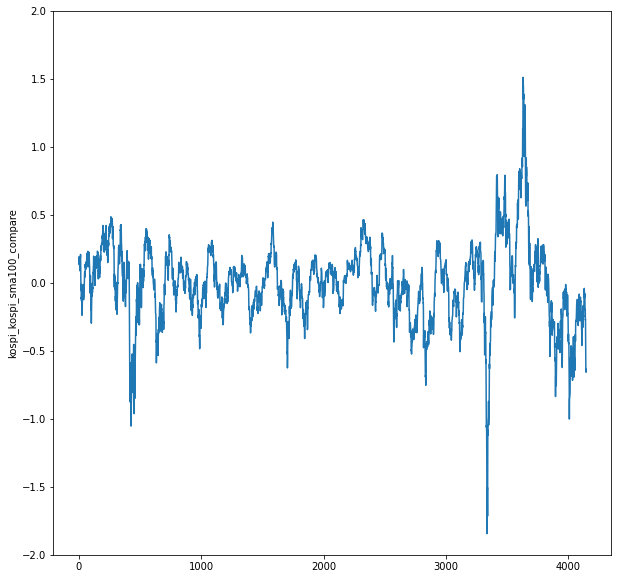

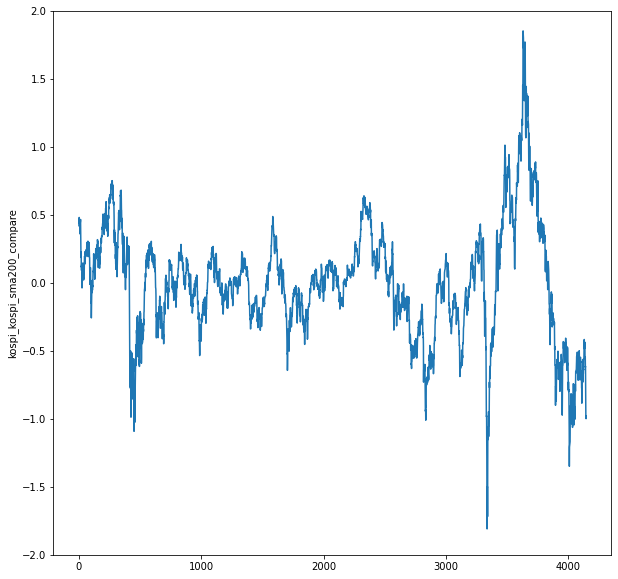

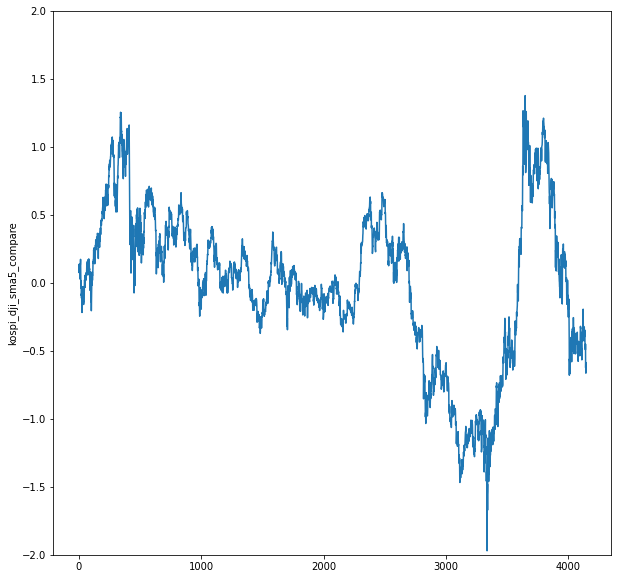

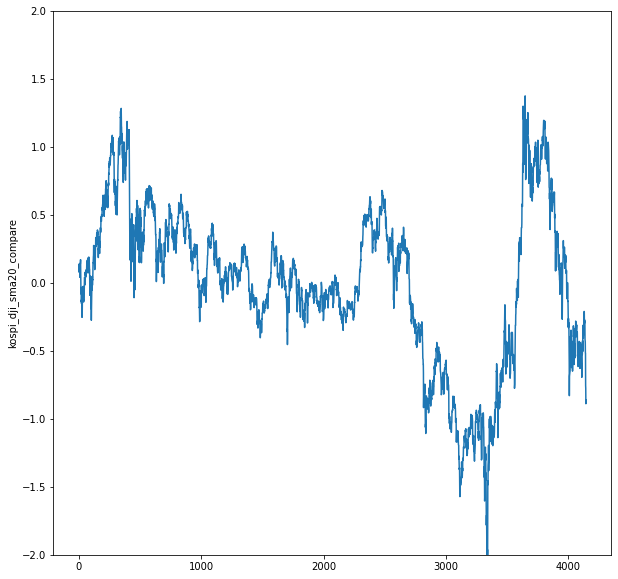

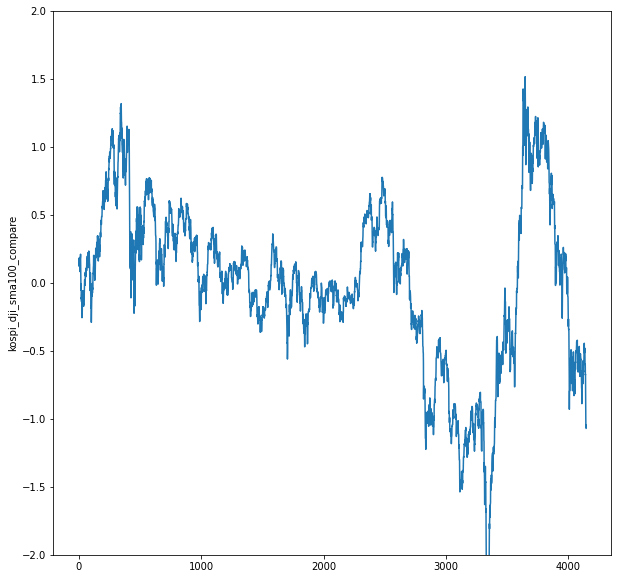

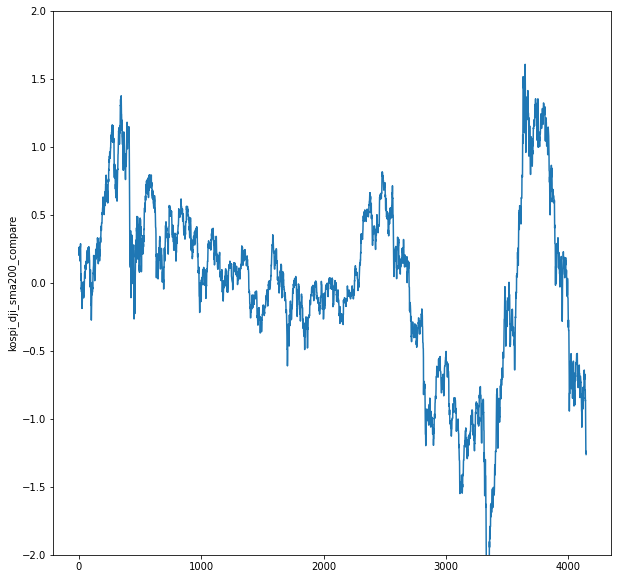

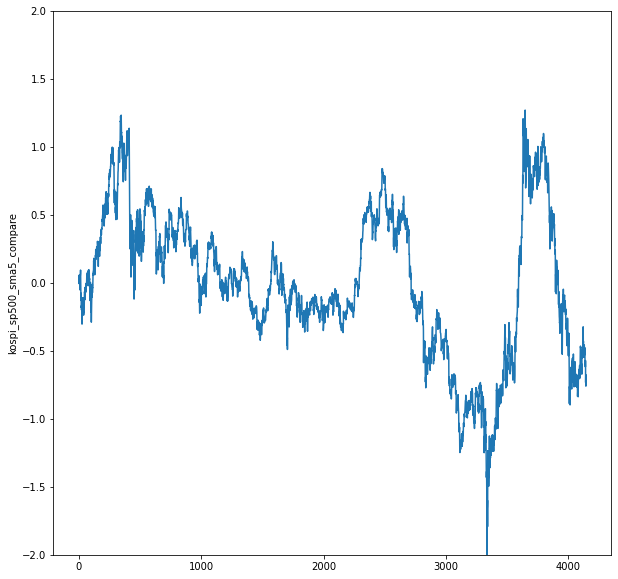

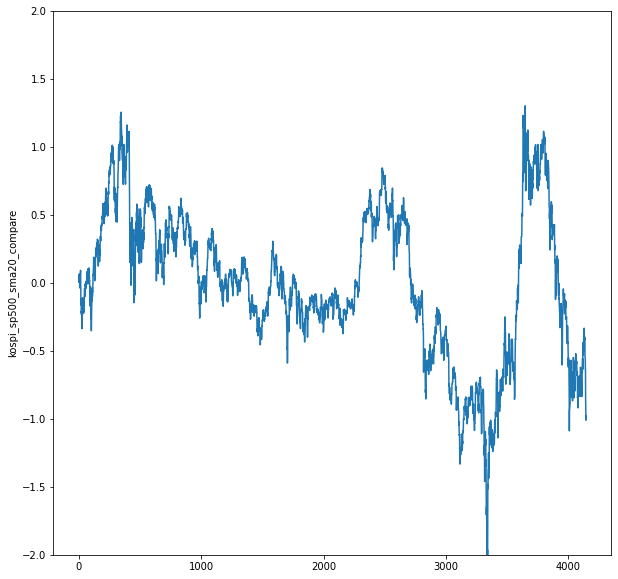

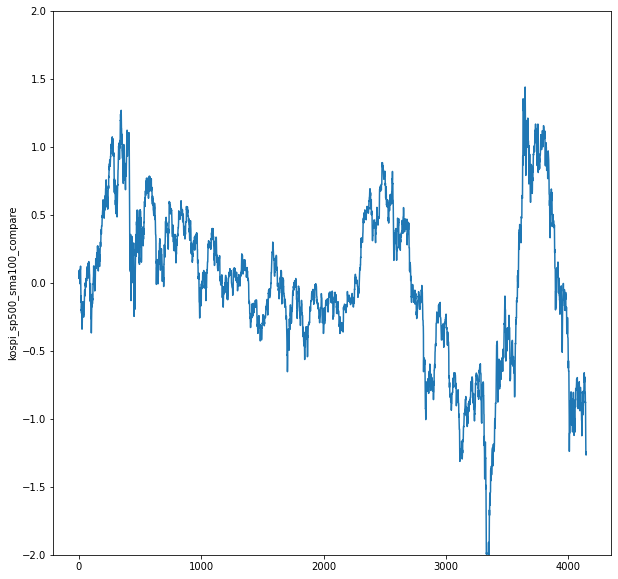

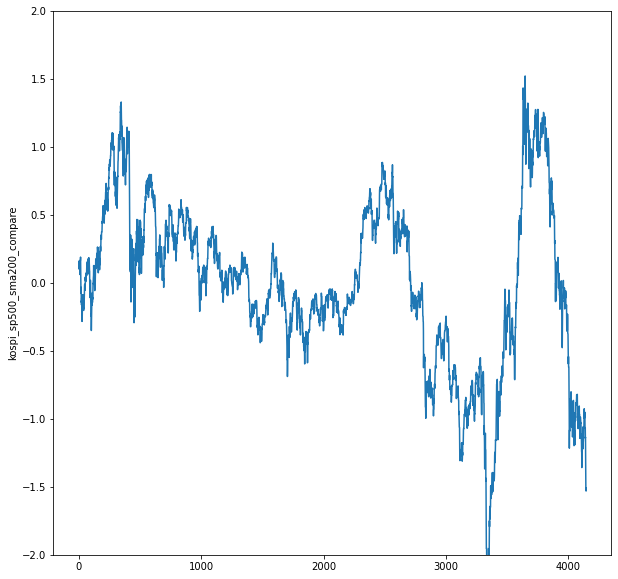

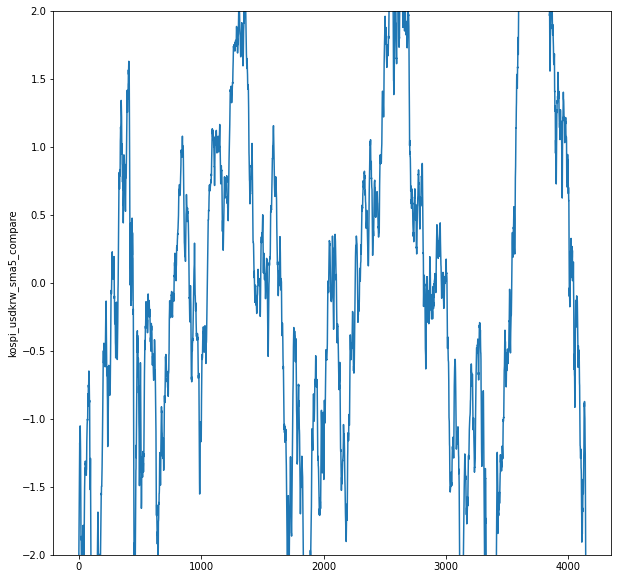

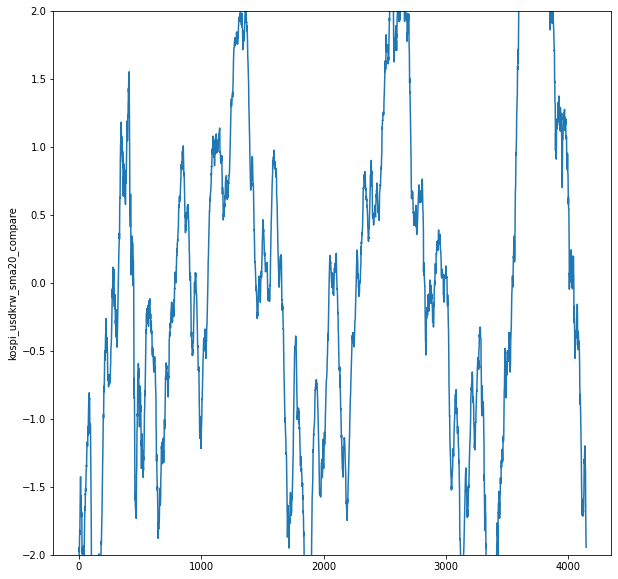

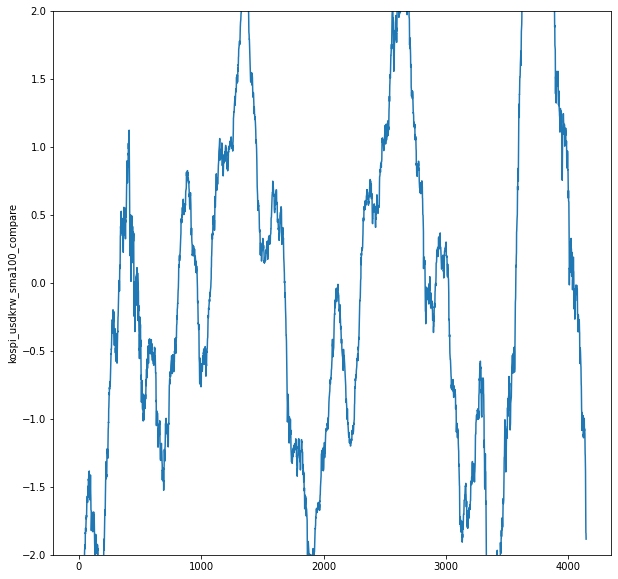

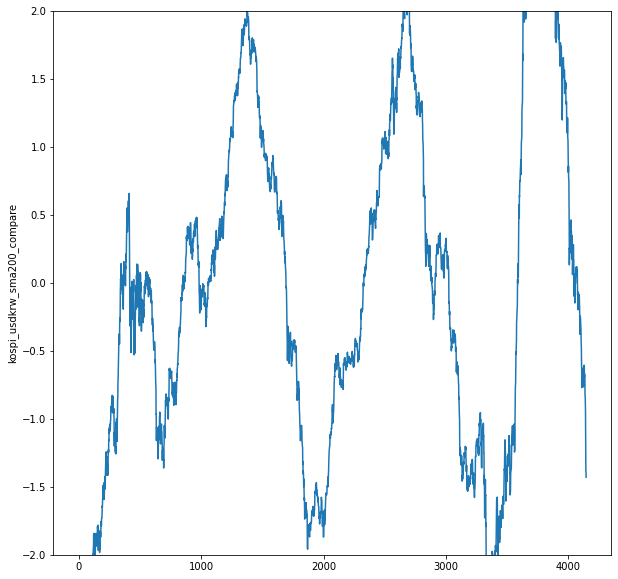

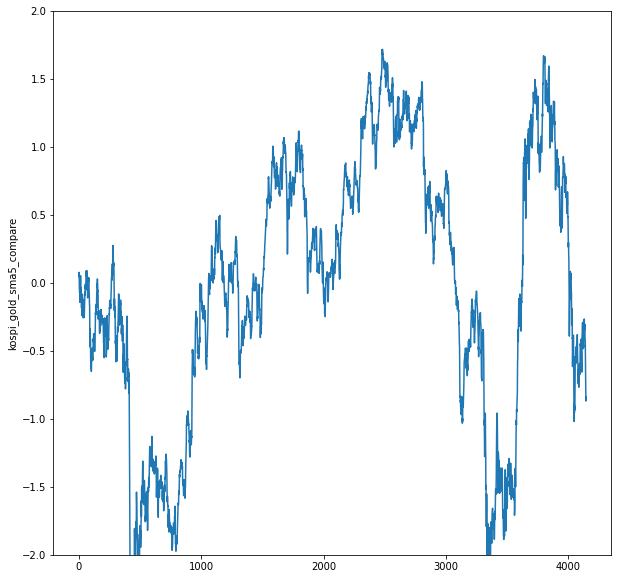

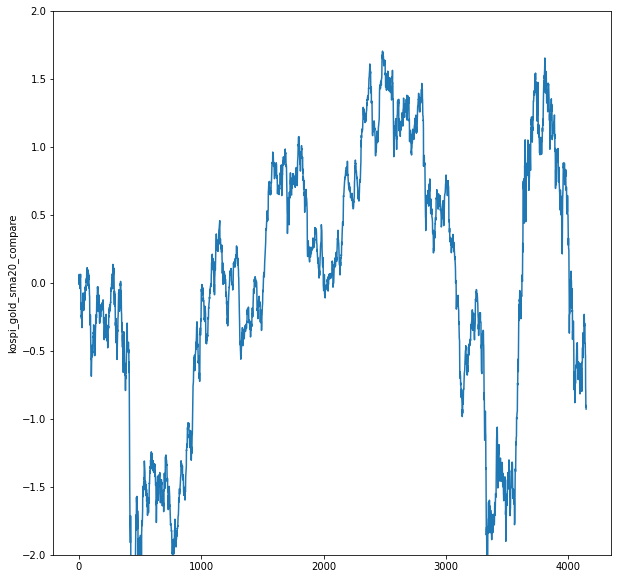

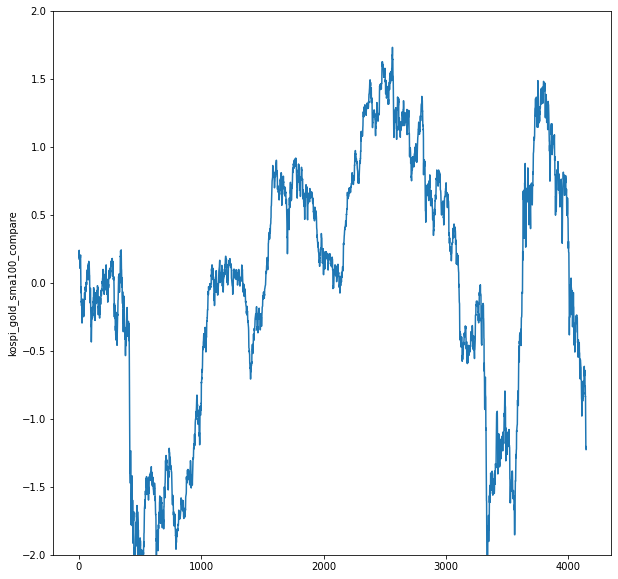

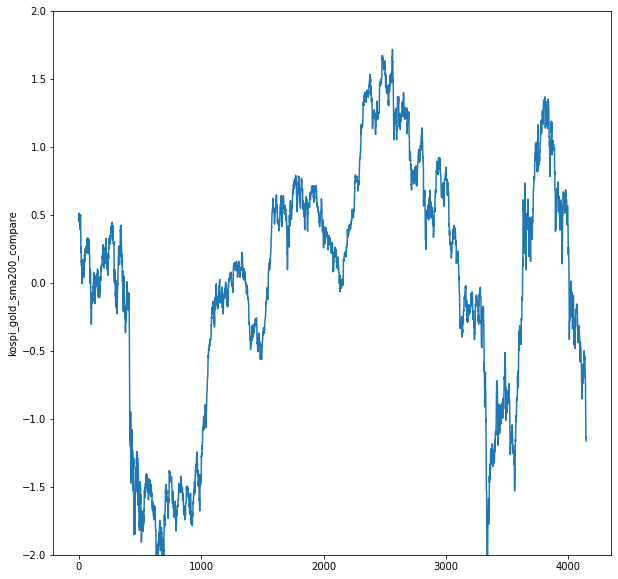

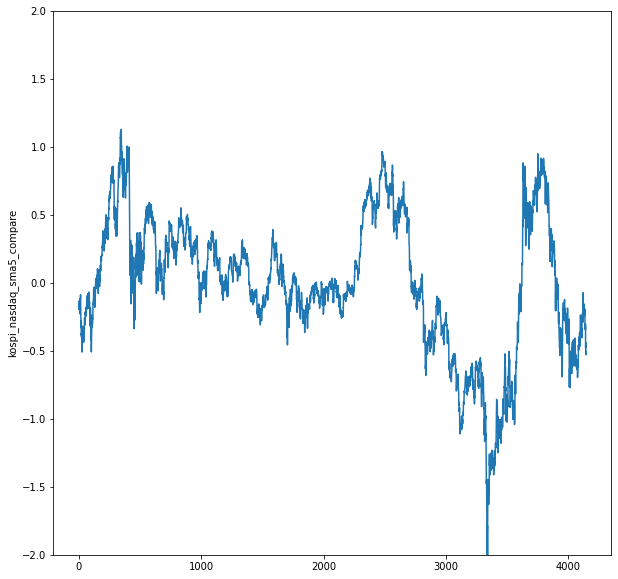

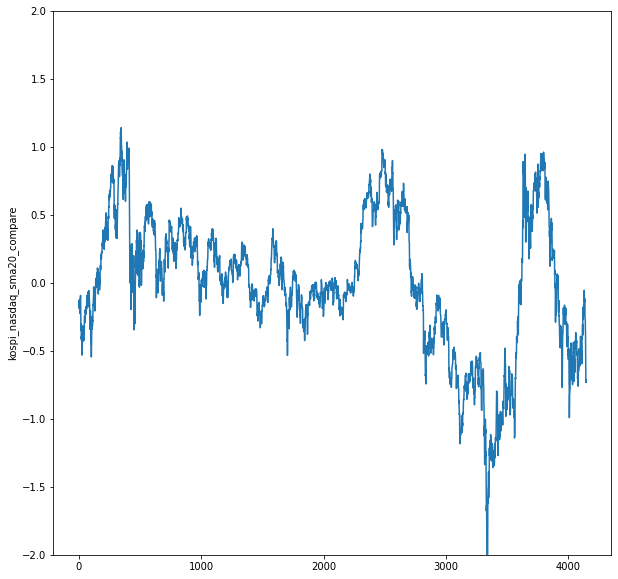

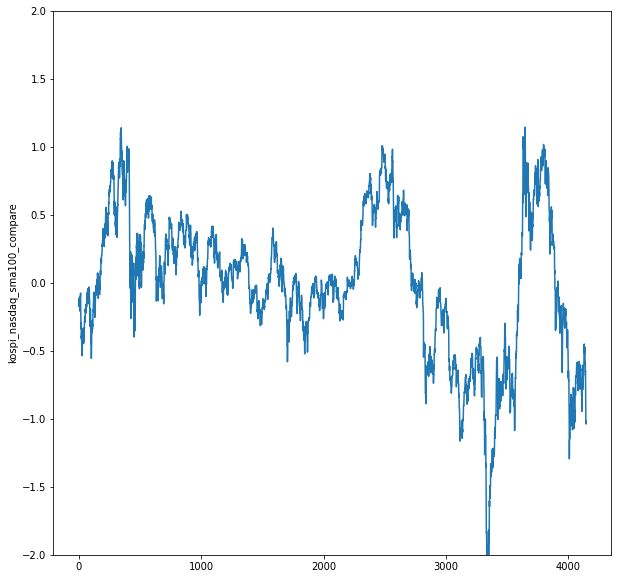

In [ ]:
for i in ko_oth_compare.columns:
  plt.figure(figsize = (10, 10))
  plt.ylim([-2, 2])
  sns.lineplot(data = ko_oth_compare[i])
  plt.show()

# kospi_kospi_sma5
# kospi_kospi_sma20
# kospi_kospi_sma100

In [ ]:
second_df = first_df.iloc[:, : 17]

In [ ]:
second_df.to_csv('/content/drive/MyDrive/이어드림스쿨/프로젝트/주가예측/data/second_df.csv')

In [7]:
second_df = pd.read_csv('/content/drive/MyDrive/이어드림스쿨/프로젝트/주가예측/data/second_df.csv')

In [8]:
second_df.head()

,Unnamed: 0,index,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse,kospi_sma5,kospi_sma20,kospi_sma100
0,0,2010-01-01,1682.77,10428.05,1115.10,1166.08,0.6981,6.8270,1095.2,3.38,5.40,0.038,3.837,2269.15,15980.0,1681.276,1661.3075,1627.0286
1,1,2010-01-04,1696.14,10583.96,1132.99,1150.00,0.6937,6.8285,1117.7,3.47,5.42,0.046,3.823,2308.42,16180.0,1683.386,1664.4820,1628.5194
2,2,2010-01-05,1690.62,10572.02,1136.52,1140.20,0.6960,6.8268,1118.1,3.47,5.36,0.036,3.763,2308.71,16440.0,1687.014,1667.6240,1629.9232
3,3,2010-01-06,1705.32,10573.68,1137.14,1129.20,0.6938,6.8278,1135.9,3.44,5.38,0.025,3.829,2301.09,16820.0,1691.524,1671.1815,1631.5168
4,4,2010-01-07,1683.45,10606.86,1141.69,1138.20,0.6985,6.8281,1133.1,3.43,5.30,0.020,3.827,2300.05,16260.0,1691.660,1672.7175,1632.5874


In [9]:
second_index = second_df.index[(second_df['index'] == '2020-04-29')].tolist()[0]
second_index

3376

In [10]:
train_df = second_df[: second_index + 1]
train_df.tail(10)

,Unnamed: 0,index,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse,kospi_sma5,kospi_sma20,kospi_sma100
3367,3367,2020-04-20,1898.36,23650.44,2823.16,1220.58,0.9205,7.0721,1703.4,0.860,1.447,0.0940,0.616,8560.727,50100.0,1899.804,1823.3255,1992.9814
3368,3368,2020-04-21,1879.38,23018.88,2736.56,1232.56,0.9208,7.0914,1678.3,0.860,1.459,0.0810,0.566,8263.230,49250.0,1904.266,1833.0215,1989.7113
3369,3369,2020-04-22,1896.15,23475.82,2799.31,1233.55,0.9239,7.0831,1727.4,0.867,1.526,0.0810,0.618,8495.379,49850.0,1900.590,1841.5860,1986.6089
3370,3370,2020-04-23,1914.73,23515.26,2797.80,1233.04,0.9276,7.0654,1733.4,0.854,1.545,0.0890,0.603,8494.754,49850.0,1900.630,1851.0505,1983.6923
3371,3371,2020-04-24,1889.01,23775.27,2836.74,1230.53,0.9239,7.0813,1724.2,0.825,1.551,0.0960,0.605,8634.520,49350.0,1895.526,1859.2290,1980.2898
3372,3372,2020-04-25,1889.01,23775.27,2836.74,1230.53,0.9239,7.0813,1724.2,0.825,1.535,0.0960,0.605,8634.520,49350.0,1893.656,1867.4075,1976.7911
3373,3373,2020-04-26,1889.01,23775.27,2836.74,1230.53,0.9239,7.0813,1724.2,0.825,1.535,0.1267,0.605,8634.520,49350.0,1895.582,1872.2640,1973.3714
3374,3374,2020-04-27,1922.77,24133.78,2878.48,1222.05,0.9232,7.0815,1712.6,0.819,1.574,0.0960,0.664,8730.164,49850.0,1900.906,1877.2225,1970.1186
3375,3375,2020-04-28,1934.09,24101.55,2863.39,1221.31,0.9240,7.0776,1710.6,0.816,1.563,0.0860,0.616,8607.730,50100.0,1904.778,1883.5700,1966.9538
3376,3376,2020-04-29,1947.56,24633.86,2939.51,1210.99,0.9194,7.0755,1713.4,0.806,1.516,0.0840,0.628,8914.711,50000.0,1916.488,1889.1375,1963.9237


In [11]:
raw_train = train_df

In [12]:
raw_train

,Unnamed: 0,index,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse,kospi_sma5,kospi_sma20,kospi_sma100
0,0,2010-01-01,1682.77,10428.05,1115.10,1166.08,0.6981,6.8270,1095.2,3.380,5.400,0.0380,3.837,2269.150,15980.0,1681.276,1661.3075,1627.0286
1,1,2010-01-04,1696.14,10583.96,1132.99,1150.00,0.6937,6.8285,1117.7,3.470,5.420,0.0460,3.823,2308.420,16180.0,1683.386,1664.4820,1628.5194
2,2,2010-01-05,1690.62,10572.02,1136.52,1140.20,0.6960,6.8268,1118.1,3.470,5.360,0.0360,3.763,2308.710,16440.0,1687.014,1667.6240,1629.9232
3,3,2010-01-06,1705.32,10573.68,1137.14,1129.20,0.6938,6.8278,1135.9,3.440,5.380,0.0250,3.829,2301.090,16820.0,1691.524,1671.1815,1631.5168
4,4,2010-01-07,1683.45,10606.86,1141.69,1138.20,0.6985,6.8281,1133.1,3.430,5.300,0.0200,3.827,2300.050,16260.0,1691.660,1672.7175,1632.5874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372,3372,2020-04-25,1889.01,23775.27,2836.74,1230.53,0.9239,7.0813,1724.2,0.825,1.535,0.0960,0.605,8634.520,49350.0,1893.656,1867.4075,1976.7911
3373,3373,2020-04-26,1889.01,23775.27,2836.74,1230.53,0.9239,7.0813,1724.2,0.825,1.535,0.1267,0.605,8634.520,49350.0,1895.582,1872.2640,1973.3714
3374,3374,2020-04-27,1922.77,24133.78,2878.48,1222.05,0.9232,7.0815,1712.6,0.819,1.574,0.0960,0.664,8730.164,49850.0,1900.906,1877.2225,1970.1186
3375,3375,2020-04-28,1934.09,24101.55,2863.39,1221.31,0.9240,7.0776,1710.6,0.816,1.563,0.0860,0.616,8607.730,50100.0,1904.778,1883.5700,1966.9538


In [ ]:
test_index = second_df.index[(second_df['index'] == '2020-05-04')].tolist()[0]
test_index

3381

In [ ]:
test_df = second_df[test_index : 3397]
test_df.head()

,index,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse,kospi_sma5,kospi_sma20,kospi_sma100
3381,2020-05-04,1895.37,23749.76,2842.74,1224.14,0.9166,7.0622,1713.3,0.795,1.499,0.094,0.631,8710.715,48500.0,1937.122,1910.1710,1948.1170
3382,2020-05-05,1895.37,23883.09,2868.44,1222.47,0.9227,7.0622,1710.6,0.795,1.496,0.094,0.662,8809.121,48500.0,1926.684,1912.0855,1944.6094
3383,2020-05-06,1928.76,23664.64,2848.42,1228.55,0.9263,7.1031,1688.5,0.786,1.506,0.086,0.709,8854.387,49200.0,1922.924,1915.6700,1941.4357
3384,2020-05-07,1928.61,23875.89,2881.19,1219.61,0.9228,7.0825,1725.8,0.774,1.486,0.084,0.639,8979.660,48800.0,1919.134,1916.3740,1938.2605
3385,2020-05-08,1945.82,24331.32,2929.80,1219.65,0.9224,7.0732,1713.9,0.762,1.426,0.096,0.685,9121.320,48800.0,1918.786,1917.9385,1935.2574


In [ ]:
raw_test = test_df

In [ ]:
print(raw_train.shape, raw_test.shape)

(3377, 17) (16, 17)


In [14]:
train_y = raw_train.kospi
train_y

0       1682.77
1       1696.14
2       1690.62
3       1705.32
4       1683.45
         ...   
3372    1889.01
3373    1889.01
3374    1922.77
3375    1934.09
3376    1947.56
Name: kospi, Length: 3377, dtype: float64

In [16]:
train_x = raw_train.iloc[:,3:]

In [18]:
train_Y = train_y.to_numpy()
train_X = train_x.to_numpy()

In [19]:
print(train_Y.shape, train_X.shape)

(3377,) (3377, 15)


## DATA SPLIT

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 5, test_size = 2) # 하나의 Iterator가 만들어진거고 (CV 5개)
for tr_idx, va_idx in tscv.split(raw_train): # for 문으로 돌릴건데 나오는 값이 train index, valid index
    # TO DO:
    # 1. 뽑아낸 인덱스를 이용하여 해당 CV에서의 dataset을 정의해준다.
    # tr_x, va_x = ... ... (제일 좋은 코딩 = index의 array가 나온다 = 그냥 마지막 값으로 인덱싱한다 :tr_idx[-1], va_idx = tr_idx[-1]+1, tr_idx[-1]:va_idx[-1])
    # numpy 형식이어야지 sklearn에다가 쓸 수 있겠지? train_x_np, train_y_np
    # TO DO:
    # 2. 이 데이터를 그냥 input으로 모델을 돌리면 됩니다.
    # for 문 바깥에서 모델은 이미 정의가 되어있고
    # 매 iterator(CV)마다 학습이 진행이 되면 됩니다!
    tr_x, va_x = train_X.iloc[tr_idx], train_X.iloc[va_idx]
    tr_y, va_y = train_Y.iloc[tr_idx], train_Y.iloc[va_idx]

    # del, gc.collect() (import gc)

In [29]:
from xgboost.sklearn import XGBRegressor

In [31]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 5, test_size = 10) # 하나의 Iterator가 만들어진거고 (CV 5개)
first_val = []
for tr_idx, va_idx in tscv.split(raw_train): # for 문으로 돌릴건데 나오는 값이 train index, valid index
    
    tr_x, va_x = train_X[tr_idx], train_X[va_idx]
    tr_y, va_y = train_Y[tr_idx], train_Y[va_idx]

    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
    
    xgb_model.fit(tr_x, tr_y)
    predictions = xgb_model.predict(va_x)
    first_val.append(predictions)

    mse = mean_squared_error(va_y, predictions)
    print('------------')
    print('mse :', mse)
    print('rmse :', math.sqrt(mse))
    print('------------')

first_val

[06:20:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
------------
mse : 10742.760852134914
rmse : 103.64729061646963
------------
[06:20:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
------------
mse : 12195.891124248343
rmse : 110.43500859894176
------------
[06:20:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
------------
mse : 1146.386599487099
rmse : 33.85833131575003
------------
[06:20:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
------------
mse : 436.304047830629
rmse : 20.88789237406754
------------
[06:20:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
------------
mse : 295.29691426598254
rmse : 17.18420537196825

[array([1960.0864, 1912.6656, 1884.7734, 1848.4263, 1812.5302, 1775.4983,
        1744.2428, 1718.7549, 1671.9272, 1650.5569], dtype=float32),
 array([1569.377 , 1563.9575, 1527.3523, 1524.9963, 1526.7354, 1522.0924,
        1542.14  , 1614.2338, 1632.1139, 1645.0283], dtype=float32),
 array([1730.3694, 1708.1182, 1716.6204, 1708.668 , 1708.668 , 1708.668 ,
        1737.7571, 1758.229 , 1781.4934, 1796.3451], dtype=float32),
 array([1859.028 , 1873.1818, 1872.5547, 1862.9933, 1868.3097, 1859.6635,
        1858.7303, 1873.2072, 1890.6301, 1898.3041], dtype=float32),
 array([1923.6112, 1915.4968, 1912.9344, 1904.3253, 1901.1785, 1901.1785,
        1901.1785, 1932.5264, 1925.1372, 1946.3804], dtype=float32)]

In [ ]:
mse = mean_squared_error(v_val, predictions)
print('mse :', mse)
print('rmse :', math.sqrt(mse))

In [ ]:
X = raw_train
y = raw_test

## 한경훈님 자료

In [ ]:
last_index = full_df.index[(full_df['index'] == '2020-05-19')].tolist()[0]
last_index
# validation set 을 이렇게 구분해버려도 될까요?
# 시계열 데이터에서의 valid set은 어떻게 하나요?

3395

In [ ]:
# Truncate df until 2020-05-19

truncated_df = full_df[:last_index+1]

In [ ]:
truncated_df.tail(20)

,index,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse
3376,2020-04-30,1947.56,24345.72,2912.43,1212.94,0.9125,7.0600,1694.2,0.806,1.517,0.0890,0.646,8889.551,50000.0
3377,2020-05-01,1947.56,23723.69,2830.71,1224.89,0.9105,7.0602,1700.9,0.806,1.517,0.1010,0.618,8604.949,50000.0
3378,2020-05-02,1947.56,23723.69,2830.71,1224.89,0.9105,7.0602,1700.9,0.806,1.517,0.1010,0.618,8604.949,50000.0
3379,2020-05-03,1947.56,23723.69,2830.71,1224.89,0.9105,7.0602,1700.9,0.806,1.517,0.1014,0.618,8604.949,50000.0
3380,2020-05-04,1895.37,23749.76,2842.74,1224.14,0.9166,7.0622,1713.3,0.795,1.499,0.0940,0.631,8710.715,48500.0
3381,2020-05-05,1895.37,23883.09,2868.44,1222.47,0.9227,7.0622,1710.6,0.795,1.496,0.0940,0.662,8809.121,48500.0
3382,2020-05-06,1928.76,23664.64,2848.42,1228.55,0.9263,7.1031,1688.5,0.786,1.506,0.0860,0.709,8854.387,49200.0
3383,2020-05-07,1928.61,23875.89,2881.19,1219.61,0.9228,7.0825,1725.8,0.774,1.486,0.0840,0.639,8979.660,48800.0
3384,2020-05-08,1945.82,24331.32,2929.80,1219.65,0.9224,7.0732,1713.9,0.762,1.426,0.0960,0.685,9121.320,48800.0
3385,2020-05-09,1945.82,24331.32,2929.80,1219.65,0.9224,7.0732,1713.9,0.757,1.425,0.0960,0.685,9121.320,48800.0


In [ ]:
split_index = truncated_df.index[(truncated_df['index'] == '2020-05-02')].tolist()[0]
split_index

3378

In [ ]:
truncated_df = truncated_df.drop('index', axis=1)

In [ ]:
# X_train, X_val, X_test = truncated_df[:int(len(truncated_df)*0.9)], \
#                          truncated_df[int(len(truncated_df)*0.9):2268], \
#                          truncated_df[2268:2278]

X_train, X_test = truncated_df[:split_index], truncated_df[split_index:last_index]

In [ ]:
X_test.tail()

,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse
3390,1924.96,23625.34,2852.50,1227.03,0.9254,7.0935,1740.9,0.751,1.382,0.0840,0.617,8943.723,48000.0
3391,1927.28,23685.42,2863.70,1232.69,0.9245,7.1013,1756.3,0.748,1.384,0.0940,0.644,9014.559,47850.0
3392,1927.28,23685.42,2863.70,1232.69,0.9245,7.1013,1756.3,0.742,1.377,0.0940,0.644,9014.559,47850.0
3393,1927.28,23685.42,2863.70,1232.69,0.9245,7.1013,1756.3,0.742,1.377,0.1217,0.643,9014.559,47850.0
3394,1937.11,24597.37,2953.91,1225.13,0.9163,7.1086,1734.4,0.736,1.392,0.0910,0.726,9234.828,48800.0


In [ ]:
print(X_train.shape, X_test.shape)

(3378, 13) (17, 13)


In [ ]:
y_train, y_test = truncated_df[['kospi']][1:split_index+1], \
                  truncated_df[['kospi']][split_index+1:]

In [ ]:
y_test.tail()

,kospi
3391,1927.28
3392,1927.28
3393,1927.28
3394,1937.11
3395,1980.61


In [ ]:
print(y_train.shape, y_test.shape)

(3378, 1) (17, 1)


In [ ]:
# Backup data

file_name = 'truncated_df.xlsx'
truncated_df.to_excel(file_name)

### 2-2 Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X_train)
scaled_X_train = minMaxScaler.transform(X_train)

In [ ]:
scaled_X_test = minMaxScaler.transform(X_test)

#### 3. Learning

- 3-1) XGBoost

In [ ]:
import xgboost
import math
from sklearn.metrics import mean_squared_error

In [ ]:
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [ ]:
xgb_model.fit(X_train, y_train)

[05:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.08, max_depth=7, subsample=0.75)

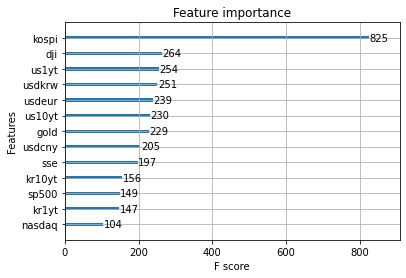

In [ ]:
xgboost.plot_importance(xgb_model)

In [ ]:
predictions = xgb_model.predict(X_test)
predictions

array([1948.4064, 1948.4064, 1895.4456, 1895.4045, 1936.9751, 1937.7408,
       1945.7427, 1945.7427, 1945.7427, 1942.9784, 1928.809 , 1952.2196,
       1933.087 , 1938.4053, 1938.4053, 1939.7557, 1950.1633],
      dtype=float32)

In [ ]:
mse = mean_squared_error(y_test, predictions)
print('mse :', mse)
print('rmse :', math.sqrt(mse))

mse : 393.79718954187854
rmse : 19.84432386204878


In [ ]:
xgb_model.fit(scaled_X_train, y_train)

[05:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.08, max_depth=7, subsample=0.75)

In [ ]:
predictions = xgb_model.predict(scaled_X_test)
predictions

array([1948.4064, 1948.4064, 1895.4456, 1895.4045, 1936.9751, 1937.7408,
       1945.7427, 1945.7427, 1945.7427, 1942.9784, 1928.809 , 1952.2196,
       1933.087 , 1938.4053, 1938.4053, 1939.7557, 1950.1633],
      dtype=float32)

In [ ]:
mse = mean_squared_error(y_test, predictions)
print('mse :', mse)
print('rmse :', math.sqrt(mse))

mse : 393.79718954187854
rmse : 19.84432386204878


- 3-2) XGBRegressor with GridSearchCV

In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# Various hyper-parameters to tune

xgb1 = XGBRegressor()
parameters = {'nthread':[3], # when use hyperthread, xgboost may become slower
              'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09],
              'max_depth': [3, 4, 5, 6, 7],
              'min_child_weight': [3, 4, 5],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100, 300, 500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 225 candidates, totalling 450 fits
[05:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2, estimator=XGBRegressor(), n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09],
                         'max_depth': [3, 4, 5, 6, 7],
                         'min_child_weight': [3, 4, 5],
                         'n_estimators': [100, 300, 500], 'nthread': [3],
                         'subsample': [0.7]},
             verbose=True)

In [ ]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.6978597778345268
{'colsample_bytree': 0.7, 'learning_rate': 0.09, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 3, 'subsample': 0.7}


In [ ]:
predictions = xgb_grid.predict(X_test)
predictions

array([1947.199 , 1947.199 , 1898.066 , 1896.0826, 1956.256 , 1935.7604,
       1944.9783, 1944.9783, 1944.7307, 1954.9199, 1928.7308, 1961.4761,
       1947.4053, 1951.641 , 1950.3099, 1944.5563, 1956.0411],
      dtype=float32)

In [ ]:
mse = mean_squared_error(y_test, predictions)
print('mse :', mse)
print('rmse :', math.sqrt(mse))

mse : 555.6460594499104
rmse : 23.572145838890236


In [ ]:
xgb_grid.fit(scaled_X_train, y_train)

Fitting 2 folds for each of 225 candidates, totalling 450 fits
[05:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2, estimator=XGBRegressor(), n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09],
                         'max_depth': [3, 4, 5, 6, 7],
                         'min_child_weight': [3, 4, 5],
                         'n_estimators': [100, 300, 500], 'nthread': [3],
                         'subsample': [0.7]},
             verbose=True)

In [ ]:
predictions = xgb_grid.predict(scaled_X_test)
predictions

array([1943.748 , 1943.748 , 1901.118 , 1899.992 , 1952.1913, 1938.5756,
       1945.2517, 1945.2517, 1943.7863, 1945.8085, 1923.6598, 1955.8151,
       1937.6769, 1947.707 , 1946.376 , 1939.7628, 1944.7717],
      dtype=float32)

In [ ]:
mse = mean_squared_error(y_test, predictions)
print('mse :', mse)
print('rmse :', math.sqrt(mse))

mse : 462.8407419267111
rmse : 21.513733797895497


- 3-3) LSTM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = truncated_df.columns.tolist()

# 스케일 후 columns
scaled = scaler.fit_transform(truncated_df)
scaled

array([[0.20910964, 0.04517909, 0.04671323, ..., 0.95212156, 0.0280413 ,
        0.05286885],
       [0.20426987, 0.04457804, 0.04820674, ..., 0.93491972, 0.02807884,
        0.05819672],
       [0.21715839, 0.0446616 , 0.04846905, ..., 0.95384174, 0.02709248,
        0.06598361],
       ...,
       [0.41176625, 0.70470588, 0.77895726, ..., 0.04042431, 0.89610609,
        0.70184426],
       [0.4203849 , 0.75061339, 0.8171241 , ..., 0.06422018, 0.92461843,
        0.72131148],
       [0.4585244 , 0.73095514, 0.80402104, ..., 0.05447248, 0.91818212,
        0.75204918]])

In [ ]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [ ]:
# # Normalization 미적용

# df = truncated_df.copy()
# df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, \
    df['kospi'], test_size=0.2, random_state=0, shuffle=False)

In [ ]:
X_train.shape, y_train.shape

((2716, 13), (2716,))

In [ ]:
X_test.shape, y_test.shape

((680, 13), (680,))

In [ ]:
X_train

,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse
0,0.209110,0.045179,0.046713,0.534663,0.066944,0.692193,0.081049,0.906005,1.000000,0.034469,0.952122,0.028041,0.052869
1,0.204270,0.044578,0.048207,0.497436,0.074922,0.690698,0.081526,0.906005,0.988930,0.030507,0.934920,0.028079,0.058197
2,0.217158,0.044662,0.048469,0.455651,0.067291,0.691577,0.102741,0.898172,0.992620,0.026149,0.953842,0.027092,0.065984
3,0.197983,0.046332,0.050394,0.489839,0.083593,0.691841,0.099404,0.895561,0.977860,0.024168,0.953268,0.026958,0.054508
4,0.208338,0.046902,0.051786,0.452042,0.066944,0.691401,0.105483,0.874674,0.983395,0.024168,0.955849,0.029174,0.057787
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,0.761466,0.734205,0.717470,0.401861,0.629206,0.509759,0.244100,0.481723,0.471402,0.713154,0.676032,0.701390,0.677254
2712,0.761466,0.734205,0.717470,0.401861,0.629206,0.509759,0.244100,0.481723,0.471402,0.713154,0.676032,0.701390,0.677254
2713,0.761466,0.734205,0.717470,0.401861,0.629206,0.509759,0.244100,0.481723,0.471402,0.709984,0.674885,0.701390,0.677254
2714,0.713603,0.736005,0.720998,0.416448,0.640652,0.551081,0.228844,0.481723,0.466974,0.755151,0.679186,0.708818,0.654713


In [ ]:
import tensorflow as tf

https://webnautes.tistory.com/1527

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=7, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
WINDOW_SIZE = 20
BATCH_SIZE = 32

In [ ]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=12,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
     11/Unknown - 3s 11ms/step - loss: 0.0879 - mse: 0.1759
Epoch 1: val_loss improved from inf to 0.05596, saving model to tmp/ckeckpointer.ckpt
13/13 [==============================] - 4s 100ms/step - loss: 0.0858 - mse: 0.1715 - val_loss: 0.0560 - val_mse: 0.1119
Epoch 2/100
10/13 [======================>.......] - ETA: 0s - loss: 0.0296 - mse: 0.0591
Epoch 2: val_loss improved from 0.05596 to 0.00491, saving model to tmp/ckeckpointer.ckpt
13/13 [==============================] - 0s 20ms/step - loss: 0.0261 - mse: 0.0523 - val_loss: 0.0049 - val_mse: 0.0098
Epoch 3/100
10/13 [======================>.......] - ETA: 0s - loss: 0.0031 - mse: 0.0063
Epoch 3: val_loss improved from 0.00491 to 0.00480, saving model to tmp/ckeckpointer.ckpt
13/13 [==============================] - 0s 22ms/step - loss: 0.0032 - mse: 0.0065 - val_loss: 0.0048 - val_mse: 0.0096
Epoch 4/100
10/13 [======================>.......] - ETA: 0s - loss: 0.0035 - mse: 0.0071
Epoch 4: val_loss improved from

In [ ]:
model.load_weights(filename)

In [ ]:
pred = model.predict(test_data)

In [ ]:
pred.shape

(95, 1)

In [ ]:
test = []
for i, value in enumerate(y_test):
    if (i+1) % 7 == 0:
        test.append(value)

In [ ]:
test = test[1:]
print(len(test))

96


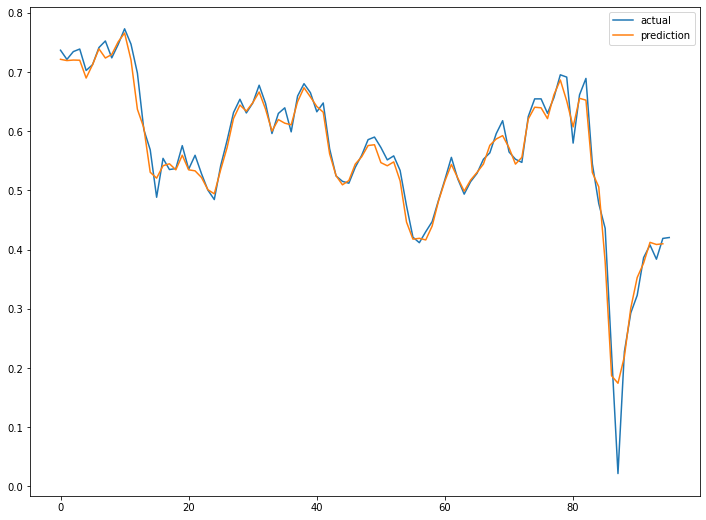

In [ ]:
plt.figure(figsize=(12, 9))
# plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(test, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()